In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets
from torchvision import transforms
import PIL
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim



    

In [2]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20), 
    transforms.ColorJitter(),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset_path = "../Data/train"
full_dataset_train = torchvision.datasets.ImageFolder(dataset_path, transform=train_transforms)
full_dataset_val = torchvision.datasets.ImageFolder(dataset_path, transform=val_transforms)



total_data = len(full_dataset_train)
train_size = int(total_data * 0.85)
val_size = total_data - train_size

indices = torch.randperm(total_data).tolist()
train_set = torch.utils.data.Subset(full_dataset_train, indices[:train_size])
val_set = torch.utils.data.Subset(full_dataset_val, indices[train_size:])

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader= torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

train_image, train_label = next(iter(train_loader))
print(f"Total Data: {total_data}")
print(f"Training Set: {len(train_set)} images")
print(f"Test Set: {len(val_set)} images")
print(f"Batch Shape (Images in 1 Batch): {train_image.shape}")

Total Data: 8000
Training Set: 6800 images
Test Set: 1200 images
Batch Shape (Images in 1 Batch): torch.Size([32, 3, 224, 224])


In [ ]:
num_classes = 7
class SkinCancerModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,kernel_size=3,padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(50176,128)
        self.fc2 = nn.Linear(128,num_classes)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        
        x = self.flatten(x)

       
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        
        return x
    
model_v3 = SkinCancerModelV2()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

criterion= nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v3.parameters(),lr=0.0001)
model_v3.to(device)
model_v3.train()

for epoch in range(15):
    total_loss = 0
    total_accuary = 0
    for image ,label in train_loader:
        image = image.to(device)
        label= label.to(device)
        predict = model_v3(image)
        loss = criterion(predict,label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions = torch.argmax(predict,dim=1)
        batch_correct = (all_predictions == label).sum().item()
        total_accuary += batch_correct

    mean_loss = total_loss / len(train_loader)

    success_rate = (total_accuary / len(train_loader.dataset)) * 100

    print(f"Epoch {epoch+1} completed. Average Loss: {total_loss/len(train_loader)},Success Rate {success_rate}")


Using device: cuda
Epoch 1 completed. Average Loss: 1.1378739020074478,Success Rate 66.94117647058823
Epoch 2 completed. Average Loss: 0.9802609998295565,Success Rate 67.27941176470588
Epoch 3 completed. Average Loss: 0.9118972664148035,Success Rate 67.5
Epoch 4 completed. Average Loss: 0.8777638139299384,Success Rate 67.98529411764706
Epoch 5 completed. Average Loss: 0.8674254918322317,Success Rate 68.25
Epoch 6 completed. Average Loss: 0.8505752591739798,Success Rate 68.94117647058823
Epoch 7 completed. Average Loss: 0.8403283275069205,Success Rate 68.6029411764706
Epoch 8 completed. Average Loss: 0.8324404027260525,Success Rate 68.80882352941177
Epoch 9 completed. Average Loss: 0.8186389161667353,Success Rate 69.35294117647058
Epoch 10 completed. Average Loss: 0.8089424616574121,Success Rate 69.58823529411765
Epoch 11 completed. Average Loss: 0.8064261129204656,Success Rate 70.02941176470588
Epoch 12 completed. Average Loss: 0.7966857598700994,Success Rate 69.94117647058825
Epoch 13

🎉 TEST RESULTS | Avg Loss: 0.7694 | Accuracy: %70.08


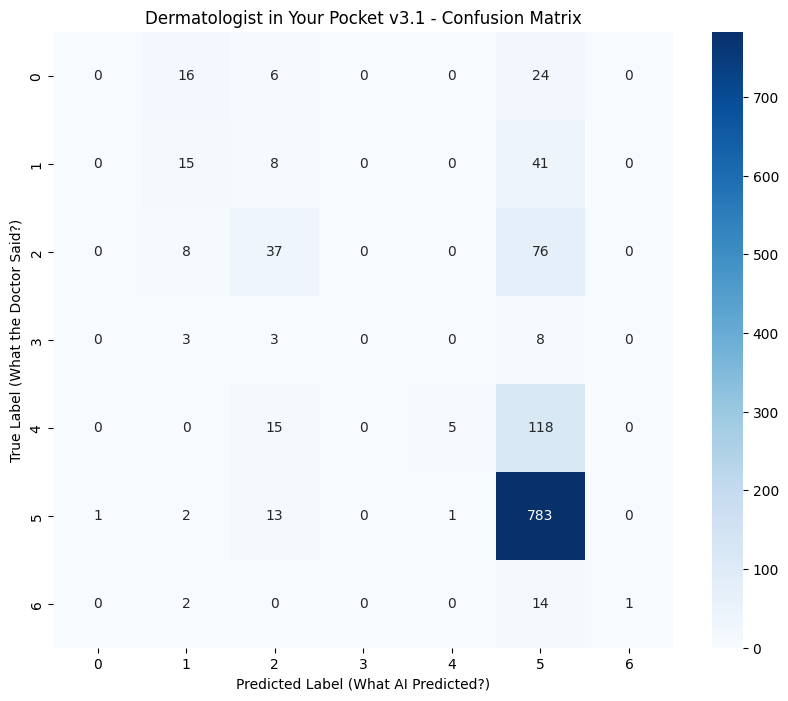

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

model_v3.eval()
model_v3 = model_v3.to(device)
criterion = nn.CrossEntropyLoss()

real_labels = []
final_predictions = []

with torch.no_grad():
    total_loss = 0
    total_accuracy = 0

    for image, label in val_loader:
        image, label = image.to(device), label.to(device)
        predict = model_v3(image)
        loss = criterion(predict, label)

        total_loss += loss.item()

        batch_preds = torch.argmax(predict, dim=1)

        batch_correct = (batch_preds == label).sum().item()
        total_accuracy += batch_correct

        final_predictions.extend(batch_preds.cpu().numpy())
        real_labels.extend(label.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    success_rate = (total_accuracy / len(val_loader.dataset)) * 100

    print(f"🎉 TEST RESULTS | Avg Loss: {avg_loss:.4f} | Accuracy: %{success_rate:.2f}")

cm = confusion_matrix(real_labels, final_predictions)

plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') 
plt.xlabel('Predicted Label (What AI Predicted?)')
plt.ylabel('True Label (What the Doctor Said?)')
plt.title('Dermatologist in Your Pocket v3.1 - Confusion Matrix')
plt.show()